In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn.metrics
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from pandas_ml import ConfusionMatrix


C:\Users\vedas\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import sklearn.preprocessing as preprocessing


In [3]:
attr_names = ['Age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','Income']
data = pd.read_csv("data.csv",delimiter='\,',names=attr_names)
data['Age'] = data['Age'].apply(lambda x: x.replace('"', ''))
data['Income'] = data['Income'].apply(lambda x: x.replace('"', ''))

C:\Users\vedas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [4]:
col_names = data.columns
num_data = data.shape[0]

for c in col_names:
    num_non = data[c].isin([" ?"]).sum()
    if num_non > 0:
        print (c)
        print (num_non)
        print ("{0:.2f}%".format(float(num_non) / num_data * 100))
        print ("\n")

workclass
1836
5.64%


occupation
1843
5.66%


native-country
583
1.79%




In [5]:
data = data[data["occupation"] != " ?"]
data["workclass"].replace(to_replace=" ?", value="Private")
data["native-country"].replace(to_replace=" ?", value="United-States").head(2)

0     United-States
1     United-States
Name: native-country, dtype: object

In [6]:
data['Age'] = pd.to_numeric(data['Age'], errors='coerce')

In [7]:
data.nunique()

Age                  72
workclass             7
fnlwgt            20495
education            16
education-num        16
marital-status        7
occupation           14
relationship          6
race                  5
sex                   2
capital-gain        118
capital-loss         90
hours-per-week       94
native-country       42
Income                2
dtype: int64

In [8]:
data.describe()

,Age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,30718.000000,3.071800e+04,30718.000000,30718.000000,30718.000000,30718.000000
mean,38.443584,1.898455e+05,10.130314,1106.037079,88.910216,40.949313
std,13.118227,1.054583e+05,2.562469,7497.863364,405.657203,11.985382
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178285e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.785170e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.373170e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [9]:
b, c = np.unique(data['Income'], return_inverse=True) 
data['Income'] = c
data.corr()

,Age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,Income
Age,1.000000,-0.076540,0.043567,0.080392,0.060409,0.101879,0.242431
fnlwgt,-0.076540,1.000000,-0.043509,-0.000189,-0.010011,-0.022810,-0.009446
education-num,0.043567,-0.043509,1.000000,0.124247,0.079321,0.151241,0.334640
capital-gain,0.080392,-0.000189,0.124247,1.000000,-0.032332,0.079548,0.221871
capital-loss,0.060409,-0.010011,0.079321,-0.032332,1.000000,0.053961,0.151461
hours-per-week,0.101879,-0.022810,0.151241,0.079548,0.053961,1.000000,0.228547
Income,0.242431,-0.009446,0.334640,0.221871,0.151461,0.228547,1.000000


In [10]:
b, c = np.unique(data['Income'], return_inverse=True) 
data['Income'] = c

#b, c = np.unique(data['sex'], return_inverse=True) 
#data['sex'] = c

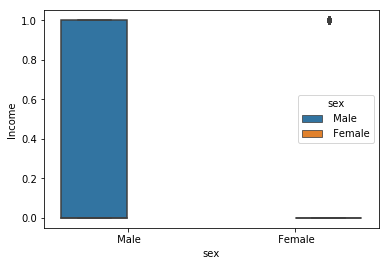

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(y='Income',x='sex',data=data,hue='sex')
plt.show()

In [12]:
data['capital-loss'] = pd.cut(data['capital-loss'], 500)
data['capital-gain'] = pd.cut(data['capital-gain'], 1500)
data['hours-per-week'] = pd.cut(data['hours-per-week'], 2)
data['Age'] = pd.cut(data['Age'], 11)
#include age also
data.head(10)

,Age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,"(36.909, 43.545]",State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,"(2133.312, 2199.978]","(-4.356, 8.712]","(0.902, 50.0]",United-States,0
1,"(43.545, 50.182]",Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,"(-99.999, 66.666]","(-4.356, 8.712]","(0.902, 50.0]",United-States,0
2,"(36.909, 43.545]",Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,"(-99.999, 66.666]","(-4.356, 8.712]","(0.902, 50.0]",United-States,0
3,"(50.182, 56.818]",Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,"(-99.999, 66.666]","(-4.356, 8.712]","(0.902, 50.0]",United-States,0
4,"(23.636, 30.273]",Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,"(-99.999, 66.666]","(-4.356, 8.712]","(0.902, 50.0]",Cuba,0
5,"(36.909, 43.545]",Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,"(-99.999, 66.666]","(-4.356, 8.712]","(0.902, 50.0]",United-States,0
6,"(43.545, 50.182]",Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,"(-99.999, 66.666]","(-4.356, 8.712]","(0.902, 50.0]",Jamaica,0
7,"(50.182, 56.818]",Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,"(-99.999, 66.666]","(-4.356, 8.712]","(0.902, 50.0]",United-States,1
8,"(30.273, 36.909]",Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,"(14066.526, 14133.192]","(-4.356, 8.712]","(0.902, 50.0]",United-States,1
9,"(36.909, 43.545]",Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,"(5133.282, 5199.948]","(-4.356, 8.712]","(0.902, 50.0]",United-States,1


In [13]:
category_col = list(data.columns)
for col in category_col:
    b, c = np.unique(data[col], return_inverse=True) 
    data[col] = c

In [14]:
data.head(10)

,Age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,3,5,2517,9,12,4,0,1,4,1,16,0,0,39,0
1,4,4,2754,9,12,2,3,0,4,1,0,0,0,39,0
2,3,2,13330,11,8,0,5,1,4,1,0,0,0,39,0
3,5,2,14522,1,6,2,5,0,2,1,0,0,0,39,0
4,1,2,18329,9,12,2,9,5,2,0,0,0,0,5,0
5,3,2,16762,12,13,2,3,5,4,0,0,0,0,39,0
6,4,2,8069,6,4,3,7,1,2,0,0,0,0,23,0
7,5,4,12885,11,8,2,3,0,4,1,0,0,0,39,1
8,2,2,1234,12,13,4,9,1,4,0,72,0,0,39,1
9,3,2,7994,9,12,2,3,0,4,1,48,0,0,39,1


In [15]:
features = list(data.columns)
print(type(features))
#features.remove('education')
#features.remove('marital-status')
#features.remove('native-country')
features.remove('Income')
#features.remove('fnlwgt')
rf = RandomForestRegressor()
train = data.copy()
y_train = train['Income']
X_train = train[features]
rf.fit(X_train, y_train)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), features), 
             reverse=True))


<class 'list'>
Features sorted by their score:
[(0.27389999999999998, 'fnlwgt'), (0.20030000000000001, 'relationship'), (0.1173, 'education-num'), (0.1149, 'capital-gain'), (0.069699999999999998, 'occupation'), (0.068099999999999994, 'Age'), (0.042799999999999998, 'workclass'), (0.039600000000000003, 'capital-loss'), (0.017999999999999999, 'native-country'), (0.0152, 'race'), (0.015100000000000001, 'hours-per-week'), (0.014, 'education'), (0.0077000000000000002, 'marital-status'), (0.0033999999999999998, 'sex')]


In [16]:
d = {'Attribute': ['Age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country']
, 'Importance': [0.067799999999999999, 0.041099999999999998, 0.015800000000000002, 0.0132, 0.11749999999999999, 0.0076, 0.096400000000000001, 0.20200000000000001, 0.014999999999999999, 0.0035999999999999999, 0.1145, 0.038899999999999997, 0.09829999999999999, 0.018200000000000001] }
df = pd.DataFrame(data=d)


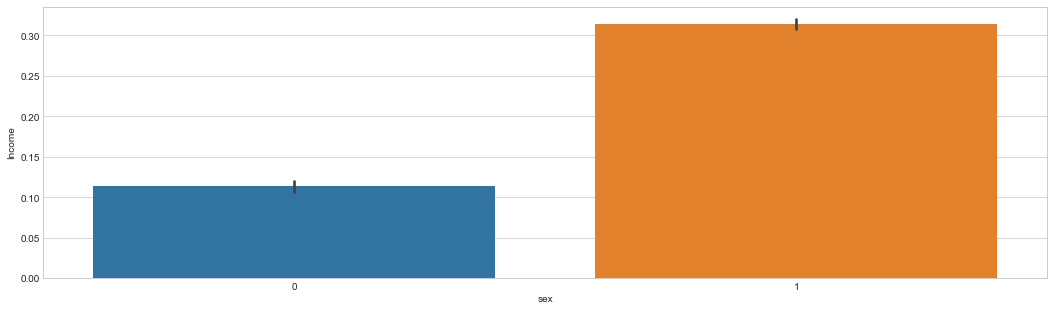

In [17]:
sns.set_style("whitegrid")
sns.set_context(rc={"figure.figsize": (18, 4)})
import matplotlib.pyplot as pyplot
a4_dims = (18, 5)

fig, ax = pyplot.subplots(figsize=a4_dims)

ax = sns.barplot(x="sex", y="Income", data=data, ax=ax)
plt.show()

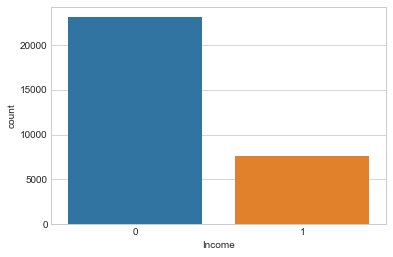

In [18]:
ax = sns.countplot(x='Income',data=data)
plt.show()

In [19]:
d = {'attr name':'>50k']
, 'imp': [0.067799999999999999, 0.041099999999999998, 0.015800000000000002, 0.0132, 0.11749999999999999, 0.0076, 0.096400000000000001, 0.20200000000000001, 0.014999999999999999, 0.0035999999999999999, 0.1145, 0.038899999999999997, 0.09829999999999999, 0.018200000000000001] }
df = pd.DataFrame(data=d)

SyntaxError: invalid syntax (<ipython-input-19-3da1084d3052>, line 1)

In [ ]:
features.remove('race')
features.remove('sex')
final_features = features

train = data.copy()
y_train = train["Income"]
x_train = train[final_features]
print(len(x_train))

In [ ]:
#TEST DATA
test_data = pd.read_csv("testdata.csv",delimiter='\,',names=attr_names)
test_data['Age'] = test_data['Age'].apply(lambda x: x.replace('"', ''))
test_data['Income'] = test_data['Income'].apply(lambda x: x.replace('"', ''))
test_data['Age'] = pd.to_numeric(test_data['Age'], errors='coerce')

In [ ]:
test_data = test_data[test_data["occupation"] != " ?"]
test_data["workclass"].replace(to_replace=" ?", value="Private")
test_data["native-country"].replace(to_replace=" ?", value="United-States")


In [ ]:
test_data['capital-loss'] = pd.cut(test_data['capital-loss'], 500)
test_data['capital-gain'] = pd.cut(test_data['capital-gain'], 1500)
test_data['hours-per-week'] = pd.cut(test_data['hours-per-week'], 2)
test_data['Age'] = pd.cut(test_data['Age'], 11)
test_data.head(10)

In [ ]:
category_col = list(test_data.columns)
for col in category_col:
    b, c = np.unique(test_data[col], return_inverse=True) 
    test_data[col] = c

In [ ]:
test_data.head(10)

In [ ]:
x_test = test_data[final_features]
y_test = test_data['Income']

In [ ]:
    #DECISION TREE 

In [ ]:
clf = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 500, random_state=0)
clf = clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))
pred_prob = clf.predict_proba(x_test)
print("Accuracy is %s" % accuracy_score(y_test, y_pred))
pred_prob


In [ ]:
print(len(y_test))
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n%s" % cm)


print(classification_report(y_test, y_pred))



In [ ]:
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(df_confusion)

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:, 1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=21)
neigh.fit(x_train, y_train) 
y_pred = neigh.predict(x_test)
probs = neigh.predict_proba(x_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n%s" % cm)
print("Accuracy is %s" % accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

In [ ]:
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(df_confusion)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators = 17, max_depth = 3)       #max_depth 9 is ideal
rf.fit(x_train, y_train) 
y_pred = rf.predict(x_test)
probs = rf.predict_proba(x_test)
#print("Confusion matrix:\n%s" % cm)
print("Accuracy is %s" % accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

In [ ]:
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(df_confusion)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#SVM

In [ ]:
from sklearn import svm

In [ ]:
clf = svm.SVC(probability = True)       
clf.fit(x_train, y_train) 
y_pred = clf.predict(x_test)
#probs = clf.predict_proba(x_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n%s" % cm)
print("Accuracy is %s" % accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

In [ ]:
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(df_confusion)

In [ ]:
probs = clf.predict_proba(x_test)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
#getting probabilities for ROC Curve not trivial in SVM

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(6,7))       #every time accuracy is not same. check online for cons
clf.fit(x_train, y_train) 
y_pred = clf.predict(x_test)
probs = clf.predict_proba(x_test)
probs = clf.predict_proba(x_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n%s" % cm)
print("Accuracy is %s" % accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))


In [ ]:
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(df_confusion)


In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
